In [4]:
import random
import sys
sys.path.append("..")

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import rpy2
import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import seaborn as sns
from shapely.geometry import Point
get_ipython().magic(u'matplotlib inline')
%matplotlib inline


from connect_db import db_connection

# filter annyoing warning from pandas
import warnings
warnings.filterwarnings('ignore')

In [5]:
username='kmohan'

In [6]:
cred_location = '/mnt/data/'+username+'/TPT_tourism/connect_db/data_creds_redshift.json.nogit'
db = db_connection.DBConnection(cred_location)

In [16]:
query = """
with first_loc as (
select customer_id, mcc, first_value(location_id) over (partition by customer_id order by time_stamp asc rows between unbounded preceding and unbounded following) as first_loc,
first_value(time_stamp) over (partition by customer_id order by time_stamp asc rows between unbounded preceding and unbounded following) as st_time
from tuscany.vodafone
where mcc=262
)

select count(distinct(customer_id)),first_loc,date_trunc('month', st_time) as month
from first_loc
group by first_loc,date_trunc('month', st_time)"""

df_firstloc = db.sql_query_to_data_frame(query, cust_id=True)

In [28]:
df_firstloc.head()

,count,first_loc,month
0,20,1103961,2017-06-01
1,1,59514013,2017-12-01
2,86,3660968,2017-07-01
3,150,3025483,2017-06-01
4,8,3648133,2017-08-01


In [5]:
postgres_cred_location = '/mnt/data/'+username+'/TPT_tourism/connect_db/data_creds.json.nogit'
postgres_db = db_connection.DBConnection(postgres_cred_location)

In [6]:
query = """
with loc as (
select location_id,lat,lon,geom,st_setsrid(st_makepoint(11.1988972,43.807459),4326) as fiz
from tuscany_test.location
)

select location_id,lat,lon,St_Distance(geom,fiz) as dist
from loc
order by dist asc"""

df_firenze = postgres_db.sql_query_to_data_frame(query, cust_id=True)

In [7]:
query = """
with loc as (
select location_id,lat,lon,geom,st_setsrid(st_makepoint(10.3666507,43.6848916),4326) as pisa
from tuscany_test.location
)

select location_id,lat,lon,St_Distance(geom,pisa) as dist
from loc
order by dist asc"""

df_pisa = postgres_db.sql_query_to_data_frame(query, cust_id=True)

In [29]:
fir=df_firenze.head(10000) ## 26 nearest to Florence Airport

In [30]:
pis=df_pisa.head(10000) ## 5 nearest to Pisa Airport

In [21]:
df_firstloc.head()

,count,first_loc,month
0,20,1103961,2017-06-01
1,1,59514013,2017-12-01
2,86,3660968,2017-07-01
3,150,3025483,2017-06-01
4,8,3648133,2017-08-01


In [31]:
fir_counts = fir.merge(df_firstloc,how="inner",left_on="location_id",right_on="first_loc")

In [32]:
pis_counts = pis.merge(df_firstloc,how="inner",left_on="location_id",right_on="first_loc")

In [33]:
pis_counts.head()

,location_id,lat,lon,dist,count,first_loc,month
0,59999011,43.6808,10.3559,0.011503,2,59999011,2018-02-01
1,59999011,43.6808,10.3559,0.011503,1,59999011,2017-11-01
2,59999011,43.6808,10.3559,0.011503,12,59999011,2017-08-01
3,59999011,43.6808,10.3559,0.011503,11,59999011,2017-06-01
4,59999011,43.6808,10.3559,0.011503,5,59999011,2017-07-01


In [34]:
fir_counts.groupby('month')['count'].sum()

month
2017-05-01    1752
2017-06-01    1919
2017-07-01    1351
2017-08-01    1201
2017-09-01    1782
2017-10-01    1413
2017-11-01     569
2017-12-01     448
2018-01-01     542
2018-02-01     598
Name: count, dtype: int64

In [35]:
pis_counts.groupby('month')['count'].sum()

month
2017-05-01    1986
2017-06-01    2426
2017-07-01    1683
2017-08-01    1756
2017-09-01    2128
2017-10-01    1512
2017-11-01     426
2017-12-01     345
2018-01-01     249
2018-02-01     418
Name: count, dtype: int64

In [7]:
query = """
select count(distinct customer_id), date_part('month',time_stamp) as mon 
from tuscany.vodafone
join tuscany.location_dictionary on vodafone.location_id = location_dictionary.location_id
where pro_com = 48017
group by mon
order by mon
"""

df_florence = db.sql_query_to_data_frame(query, cust_id=True)

In [9]:
query = """
select count(distinct customer_id), date_part('month',time_stamp) as mon
from tuscany.vodafone
join tuscany.location_dictionary on vodafone.location_id = location_dictionary.location_id
where pro_com != 48017
group by mon
order by mon
"""

df_rest_of_tuscany = db.sql_query_to_data_frame(query, cust_id=True)

In [10]:
df_florence.head()

,count,mon
0,355539,1.0
1,356219,2.0
2,619652,5.0
3,704775,6.0
4,812609,7.0


In [11]:
df_rest_of_tuscany.head()

,count,mon
0,608722,1.0
1,600730,2.0
2,1167096,5.0
3,1408883,6.0
4,1823809,7.0


In [16]:
df_florence = df_florence.merge(df_rest_of_tuscany,how='inner',left_on='mon',right_on='mon')

In [17]:
df_florence = df_florence.rename(columns={'count_x':'florence','count_y':'rest_of_tuscany'})

In [18]:
df_florence.head()

,florence,mon,rest_of_tuscany
0,355539,1.0,608722
1,356219,2.0,600730
2,619652,5.0,1167096
3,704775,6.0,1408883
4,812609,7.0,1823809


In [23]:
df_florence.loc[:,'florence']

0    355539
1    356219
2    619652
3    704775
4    812609
5    835812
6    742702
7    639916
8    378954
9    352890
Name: florence, dtype: int64

In [31]:
df_ordered = pd.concat([df_florence[2:],df_florence[:2]])

In [32]:
df_ordered

,florence,mon,rest_of_tuscany
2,619652,5.0,1167096
3,704775,6.0,1408883
4,812609,7.0,1823809
5,835812,8.0,1866759
6,742702,9.0,1522033
7,639916,10.0,1151602
8,378954,11.0,653844
9,352890,12.0,606730
0,355539,1.0,608722
1,356219,2.0,600730


(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. ]),
 <a list of 7 Text yticklabel objects>)

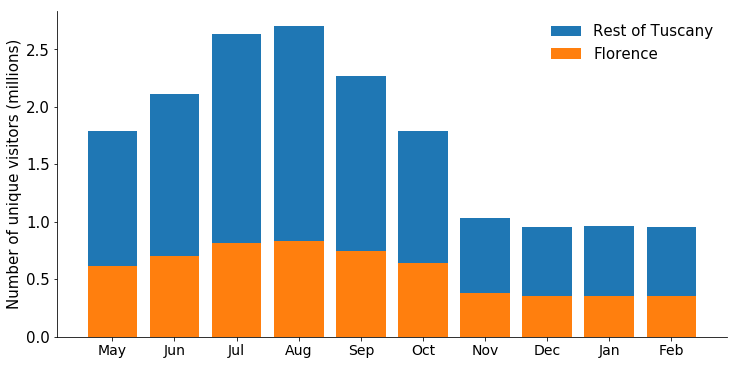

In [38]:
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(1,1,1)
names = ['May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']
plt.bar(range(len(df_ordered)), df_ordered.loc[:,'rest_of_tuscany']/1000000,tick_label=names, label='Rest of Tuscany',bottom=df_ordered.loc[:,'florence']/1000000)
plt.bar(range(len(df_ordered)), df_ordered.loc[:,'florence']/1000000,tick_label=names, label='Florence')
plt.legend(loc='best', frameon=False, fontsize=15)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.ylabel('Number of unique visitors (millions)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=15)